1. VOC 2012 Annotation을 바탕으로 y_true 추출하기
* CenterNet에 맞게 Center point를 레이블로 제공해야 함
* Gaussian kerenl을 사용할 때 adaptive sigma를 사용하지 못함(개선 필요)
2. CenterNet 함수형 API로 Porting
* 레퍼런스와 다르게 모델 레이어를 모두 함수형으로 하고 손실 함수만 직접 정의
* 현재 Width Height Head와 Offest Header을 제외한 나머지 옮김   

레퍼런스: https://github.com/bubbliiiing/centernet-tf2

In [11]:
import tensorflow as tf

resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", input_shape=(512, 512, 3)
)

resnet50.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [12]:
IMAGE_SIZE = (512, 512)
NUM_CLASSES = 20


def get_mycenternet(image_size, num_classes):
    model_in = tf.keras.Input((*image_size, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(model_in)
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False, weights="imagenet", input_shape=(*image_size, 3)
    )
    resnet50.trainable = False
    x = resnet50(x)
    num_filters = 256
    for i in range(5):
        filters = num_filters // pow(2, i)
        x = tf.keras.layers.Conv2DTranspose(
            filters,
            (4, 4),
            strides=2,
            use_bias=False,
            padding="same",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.L2(5e-4),
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

    y = tf.keras.layers.Conv2D(
        64,
        3,
        padding="same",
        use_bias=False,
        kernel_initializer=tf.keras.initializers.RandomNormal(0.02),
    )(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    model_out = tf.keras.layers.Conv2D(
        num_classes,
        1,
        activation="sigmoid",
        kernel_initializer=tf.keras.initializers.Constant(0),
        bias_initializer=tf.keras.initializers.Constant(-2.19),
    )(y)
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])


mycenternet = get_mycenternet(IMAGE_SIZE, NUM_CLASSES)
mycenternet.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 512, 512, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 256)      8388

In [13]:
TRAIN_TXT = "dataset/VOCdevkit/VOC2012/ImageSets/Main/train.txt"
VAL_TXT = "dataset/VOCdevkit/VOC2012/ImageSets/Main/val.txt"


def get_filenames(txt_path):
    with open(txt_path, "r") as file:
        return [line.replace("\n", "") for line in file.readlines()]


train_filenames = get_filenames(TRAIN_TXT)
val_filenames = get_filenames(VAL_TXT)
train_filenames[:5]


['2008_000008', '2008_000015', '2008_000019', '2008_000023', '2008_000028']

In [14]:
IMAGE_DIR = "dataset/VOCdevkit/VOC2012/JPEGImages"
ANNOTATION_DIR = "dataset/VOCdevkit/VOC2012/Annotations"
import os

train_image_paths = [os.path.join(IMAGE_DIR, name + ".jpg") for name in train_filenames]
train_label_paths = [
    os.path.join(ANNOTATION_DIR, name + ".xml") for name in train_filenames
]
train_label_paths[:5]


['dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml',
 'dataset/VOCdevkit/VOC2012/Annotations/2008_000015.xml',
 'dataset/VOCdevkit/VOC2012/Annotations/2008_000019.xml',
 'dataset/VOCdevkit/VOC2012/Annotations/2008_000023.xml',
 'dataset/VOCdevkit/VOC2012/Annotations/2008_000028.xml']

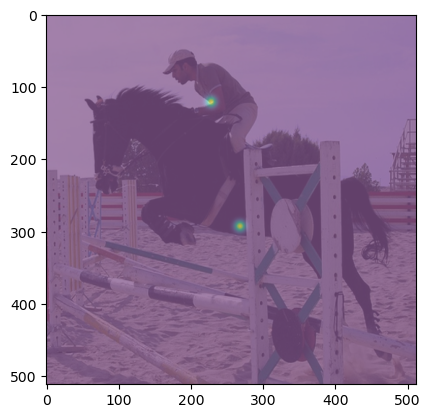

In [15]:
from PIL import Image
import numpy as np
from parse_annotation import get_label


def train_generator():
    for image_path, label_path in zip(train_image_paths, train_label_paths):
        yield (
            np.asarray(Image.open(image_path).resize(IMAGE_SIZE).convert("RGB")),
            get_label(label_path, IMAGE_SIZE),
        )


import matplotlib.pyplot as plt

for data, label in train_generator():
    sum_label = np.zeros((label.shape[0], label.shape[1]))
    for i in range(label.shape[2]):
        sum_label += label[:, :, i]
    plt.imshow(data, alpha=0.5)
    plt.imshow(sum_label, alpha=0.5)
    plt.show()
    break


In [16]:
output_signature = (
    tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    tf.TensorSpec(shape=(*IMAGE_SIZE, NUM_CLASSES), dtype=tf.float32),
)

train_dataset = tf.data.Dataset.from_generator(
    train_generator, output_signature=output_signature
)
train_dataset


<FlatMapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 20), dtype=tf.float32, name=None))>

In [17]:
def focal_loss(y_true, y_pred, alpha=2, beta=4):
    pos_mask = tf.cast(tf.equal(y_true, 1), tf.float32)
    pos_loss = (
        -tf.math.log(tf.clip_by_value(y_pred, 1e-6, 1.0))
        * tf.pow(1 - y_pred, alpha)
        * pos_mask
    )
    neg_mask = tf.cast(tf.less(y_true, 1), tf.float32)
    neg_loss = (
        -tf.math.log(tf.clip_by_value(1 - y_pred, 1e-6, 1.0))
        * tf.pow(y_pred, alpha)
        * tf.pow(1 - y_true, beta)
        * neg_mask
    )

    num_pos = tf.reduce_sum(pos_mask)
    pos_loss = tf.reduce_sum(pos_loss)
    neg_loss = tf.reduce_sum(neg_loss)
    cls_loss = tf.cond(
        tf.greater(num_pos, 0),
        lambda: (pos_loss + neg_loss) / num_pos,
        lambda: neg_loss,
    )
    return cls_loss


sample_loss = focal_loss(
    tf.cast(
        tf.expand_dims(
            get_label(
                "dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", IMAGE_SIZE
            ),
            axis=0,
        ),
        tf.float32,
    ),
    tf.cast(
        tf.expand_dims(
            get_label(
                "dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", IMAGE_SIZE
            ),
            axis=0,
        ),
        tf.float32,
    ),
)

sample_loss


<tf.Tensor: shape=(), dtype=float32, numpy=1.919862>

In [18]:
def heat_map_accuracy(y_true, y_pred):
    batch_size = tf.shape(y_true)[0]
    num_classes = tf.shape(y_true)[3]
    flattend_y_true = tf.reshape(y_true, (batch_size, -1, num_classes))
    flattend_y_pred = tf.reshape(y_pred, (batch_size, -1, num_classes))
    return tf.reduce_mean(
        tf.keras.metrics.categorical_accuracy(flattend_y_true, flattend_y_pred)
    )


sample_loss = heat_map_accuracy(
    tf.expand_dims(
        get_label("dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", IMAGE_SIZE),
        axis=0,
    ),
    tf.expand_dims(
        get_label("dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", IMAGE_SIZE),
        axis=0,
    ),
)

sample_loss


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [22]:
mycenternet.compile(
    loss=focal_loss,
    optimizer="adam",
    metrics=[
        tf.keras.metrics.MAE
    ],
)


In [25]:
history = mycenternet.fit(train_dataset.repeat(1).batch(4), epochs=1)


1430/1430 [==============================] - 2005s 1s/step - loss: 8.2689 - mean_absolute_error: 0.0090


In [28]:
mycenternet.save("mycenternet_first.h5")

['2008_000008', '2008_000015', '2008_000019', '2008_000023', '2008_000028']


1/1 [==============================] - 0s 37ms/step


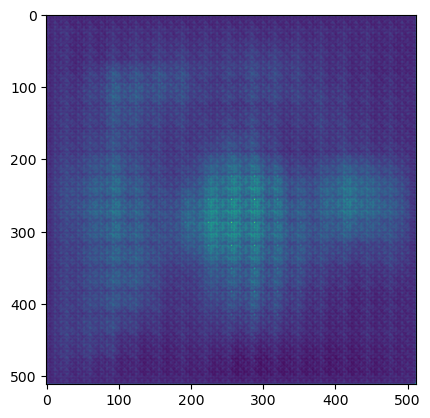

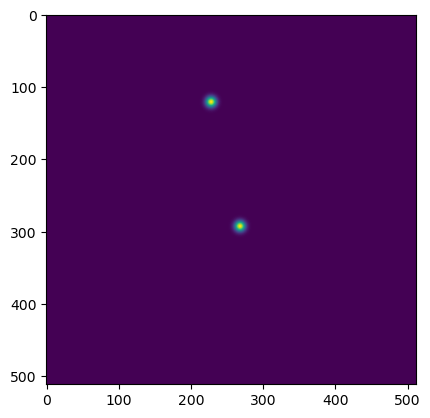

In [47]:


preds = mycenternet.predict(
    np.asarray(
        Image.open("dataset/VOCdevkit/VOC2012/JPEGImages/2008_000015.jpg")
        .resize(IMAGE_SIZE)
        .convert("RGB")
    )[np.newaxis, ...]
)
plt.imshow(preds[0, :, :, 2])
plt.show()
real = np.zeros(IMAGE_SIZE)
for i in range(NUM_CLASSES):
    real += get_label("dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", IMAGE_SIZE)[..., i]
plt.imshow(real)
plt.show()